In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ========================================
# Part 1: Data Loading and Basic Processing
# ========================================
print("=" * 50)
print("Step 1: Loading Data")
print("=" * 50)

# Load data - use the file you uploaded to Jupyter
btc = pd.read_csv("BTC-USD.csv", parse_dates=["Date"])
btc = btc.sort_values("Date").reset_index(drop=True)
btc["Date"] = pd.to_datetime(btc["Date"])

print(f"Original data shape: {btc.shape}")
print(f"Date range: {btc['Date'].min()} to {btc['Date'].max()}")
print("\nFirst 5 rows:")
print(btc.head())

# ========================================
# Part 2: Feature Engineering
# ========================================
print("\n" + "=" * 50)
print("Step 2: Feature Engineering")
print("=" * 50)

# 1. Calculate returns
btc["returns"] = btc["Close"].pct_change()

# 2. Calculate excess returns (simplified: risk-free rate = 0)
risk_free_rate = 0.0
btc["excess_returns"] = btc["returns"] - risk_free_rate

# 3. Target variable: 5-day future excess returns
horizon = 5
btc["target_excess_ret"] = btc["excess_returns"].shift(-horizon)

# 4. Technical indicator features
btc["ret_1d"] = btc["returns"]
btc["ret_5d"] = btc["Close"].pct_change(5)
btc["ret_20d"] = btc["Close"].pct_change(20)

# Price range features
btc["range_pct"] = (btc["High"] - btc["Low"]) / btc["Close"]
btc["upper_shadow"] = (btc["High"] - btc["Close"]) / btc["Close"]
btc["lower_shadow"] = (btc["Close"] - btc["Low"]) / btc["Close"]

# Volatility features
btc["vol_5d"] = btc["returns"].rolling(5).std()
btc["vol_20d"] = btc["returns"].rolling(20).std()

# Volume features
btc["vol_chg"] = btc["Volume"].pct_change()
btc["vol_ma5"] = btc["Volume"].rolling(5).mean() / btc["Volume"]

# Moving average features
btc["ma_5"] = btc["Close"].rolling(5).mean() / btc["Close"]
btc["ma_20"] = btc["Close"].rolling(20).mean() / btc["Close"]

# Remove missing values
btc = btc.dropna()

# Take first 500 samples (avoid excessive data size)
btc = btc.iloc[:500].copy()

print(f"Processed data shape: {btc.shape}")
print(f"Feature list: {btc.columns.tolist()}")

# ========================================
# Part 3: Prepare Training Data
# ========================================
print("\n" + "=" * 50)
print("Step 3: Preparing Training Data")
print("=" * 50)

# Select features
features = [
    "ret_1d", "ret_5d", "ret_20d",
    "range_pct", "upper_shadow", "lower_shadow",
    "vol_5d", "vol_20d", "vol_chg", "vol_ma5",
    "ma_5", "ma_20"
]

X = btc[features].values
y = btc["target_excess_ret"].values
dates = btc["Date"].values
actual_returns = btc["excess_returns"].values

print(f"Feature matrix X shape: {X.shape}")
print(f"Target variable y shape: {y.shape}")

# Data normalization
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split train/test sets (80/20)
split_idx = int(len(X_scaled) * 0.8)

X_train = X_scaled[:split_idx]
X_test = X_scaled[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

# Save test set actual returns (for later strategy evaluation)
test_returns = actual_returns[split_idx:]
test_dates = dates[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Reshape for LSTM input format (samples, timesteps, features)
lookback = 1  # Use 1 timestep
X_train = X_train.reshape((X_train.shape[0], lookback, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], lookback, X_test.shape[1]))

print(f"LSTM input shape: {X_train.shape}")

# ========================================
# Part 4: Build and Train Model
# ========================================
print("\n" + "=" * 50)
print("Step 4: Building and Training Model")
print("=" * 50)

# Build improved LSTM model
model = keras.Sequential([
    keras.layers.LSTM(128, return_sequences=True, 
                      input_shape=(lookback, len(features))),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train model
print("\nStarting training...")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# ========================================
# Part 5: Prediction
# ========================================
print("\n" + "=" * 50)
print("Step 5: Generating Predictions")
print("=" * 50)

y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print(f"Prediction range: [{y_pred.min():.4f}, {y_pred.max():.4f}]")
print(f"Actual value range: [{y_test_original.min():.4f}, {y_test_original.max():.4f}]")

# ========================================
# Part 6: Portfolio Strategy
# ========================================
print("\n" + "=" * 50)
print("Step 6: Implementing Portfolio Strategy")
print("=" * 50)

def compute_weights(predicted_returns, risk_aversion=10):
    """
    Calculate allocation weights (0-2) based on predicted returns
    """
    weights = []
    for pred in predicted_returns:
        if pred > 0:
            # Positive return: weight between 0-2, higher return = higher weight
            weight = min(2.0, max(0, pred * risk_aversion))
        else:
            # Negative return: weight = 0
            weight = 0.0
        weights.append(weight)
    return np.array(weights)

# Calculate initial weights
initial_weights = compute_weights(y_pred, risk_aversion=10)

# Calculate strategy returns
# Note: Using actual returns after prediction time for strategy performance
strategy_returns = initial_weights * test_returns

# Benchmark returns (buy & hold strategy)
benchmark_returns = test_returns

# Calculate volatility
strategy_vol = np.std(strategy_returns)
benchmark_vol = np.std(benchmark_returns)
vol_ratio = strategy_vol / benchmark_vol

print(f"Strategy volatility: {strategy_vol:.6f}")
print(f"Benchmark volatility: {benchmark_vol:.6f}")
print(f"Volatility ratio: {vol_ratio:.3f}")

# Apply volatility constraint (≤ 1.2× benchmark volatility)
if vol_ratio > 1.2:
    print("\n  Violates volatility constraint, adjusting weights...")
    adjustment_factor = 1.2 / vol_ratio
    adjusted_weights = initial_weights * adjustment_factor
    strategy_returns = adjusted_weights * test_returns
    
    # Recalculate volatility
    strategy_vol = np.std(strategy_returns)
    vol_ratio = strategy_vol / benchmark_vol
    print(f"Adjusted volatility ratio: {vol_ratio:.3f}")
else:
    print(" Satisfies volatility constraint")
    adjusted_weights = initial_weights

# ========================================
# Part 7: Evaluation Metrics
# ========================================
print("\n" + "=" * 50)
print("Step 7: Computing Evaluation Metrics")
print("=" * 50)

# 1. Sharpe Ratio (annualized)
def sharpe_ratio(returns, risk_free=0):
    excess = returns - risk_free
    if np.std(excess) == 0:
        return 0
    return np.mean(excess) / np.std(excess) * np.sqrt(252)

strategy_sharpe = sharpe_ratio(strategy_returns)
benchmark_sharpe = sharpe_ratio(benchmark_returns)

# 2. Cumulative returns
strategy_cumret = (1 + strategy_returns).prod() - 1
benchmark_cumret = (1 + benchmark_returns).prod() - 1

# 3. Maximum drawdown
def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()

strategy_mdd = max_drawdown(strategy_returns)
benchmark_mdd = max_drawdown(benchmark_returns)

# 4. Annualized return
def annualized_return(returns):
    total_return = (1 + returns).prod()
    n_days = len(returns)
    return total_return ** (252 / n_days) - 1

strategy_ann_ret = annualized_return(strategy_returns)
benchmark_ann_ret = annualized_return(benchmark_returns)

# Print results
print("\n" + "=" * 50)
print("Evaluation Results Summary")
print("=" * 50)
print(f"\n{'Metric':<20} {'Strategy':<15} {'Benchmark':<15}")
print("-" * 50)
print(f"{'Sharpe Ratio':<20} {strategy_sharpe:>14.3f} {benchmark_sharpe:>14.3f}")
print(f"{'Cumulative Return':<20} {strategy_cumret:>13.2%} {benchmark_cumret:>13.2%}")
print(f"{'Annualized Return':<20} {strategy_ann_ret:>13.2%} {benchmark_ann_ret:>13.2%}")
print(f"{'Maximum Drawdown':<20} {strategy_mdd:>13.2%} {benchmark_mdd:>13.2%}")
print(f"{'Volatility':<20} {strategy_vol:>14.6f} {benchmark_vol:>14.6f}")
print(f"{'Volatility Ratio':<20} {vol_ratio:>14.3f} {'1.000':>14}")

# ========================================
# Part 8: Visualization
# ========================================
print("\n" + "=" * 50)
print("Step 8: Generating Visualizations")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Training loss curve
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Cumulative returns comparison
strategy_cum = (1 + strategy_returns).cumprod()
benchmark_cum = (1 + benchmark_returns).cumprod()

axes[0, 1].plot(strategy_cum, label=f'Strategy (Sharpe: {strategy_sharpe:.2f})', linewidth=2)
axes[0, 1].plot(benchmark_cum, label=f'Buy & Hold (Sharpe: {benchmark_sharpe:.2f})', linewidth=2)
axes[0, 1].set_title('Cumulative Returns Comparison')
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Cumulative Return')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Weight distribution
axes[1, 0].hist(adjusted_weights, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(adjusted_weights.mean(), color='red', 
                   linestyle='--', label=f'Mean: {adjusted_weights.mean():.2f}')
axes[1, 0].set_title('Portfolio Weights Distribution')
axes[1, 0].set_xlabel('Weight')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Drawdown curve
def compute_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    return drawdown

strategy_dd = compute_drawdown(strategy_returns)
benchmark_dd = compute_drawdown(benchmark_returns)

axes[1, 1].plot(strategy_dd, label=f'Strategy (Max: {strategy_mdd:.2%})', linewidth=2)
axes[1, 1].plot(benchmark_dd, label=f'Benchmark (Max: {benchmark_mdd:.2%})', linewidth=2)
axes[1, 1].set_title('Drawdown Comparison')
axes[1, 1].set_xlabel('Days')
axes[1, 1].set_ylabel('Drawdown')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n All steps done")
print("\n" + "=" * 50)
print("Summary")
print("=" * 50)
print(f" Data processing: {len(btc)} samples")
print(f" Feature engineering: {len(features)} f

Step 1: Loading Data
Original data shape: (1953, 7)
Date range: 2019-01-01 00:00:00 to 2024-05-06 00:00:00

First 5 rows:
        Date         Open         High          Low        Close    Adj Close  \
0 2019-01-01  3746.713379  3850.913818  3707.231201  3843.520020  3843.520020   
1 2019-01-02  3849.216309  3947.981201  3817.409424  3943.409424  3943.409424   
2 2019-01-03  3931.048584  3935.685059  3826.222900  3836.741211  3836.741211   
3 2019-01-04  3832.040039  3865.934570  3783.853760  3857.717529  3857.717529   
4 2019-01-05  3851.973877  3904.903076  3836.900146  3845.194580  3845.194580   

       Volume  
0  4324200990  
1  5244856836  
2  4530215219  
3  4847965467  
4  5137609824  

Step 2: Feature Engineering
Processed data shape: (500, 22)
Feature list: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'returns', 'excess_returns', 'target_excess_ret', 'ret_1d', 'ret_5d', 'ret_20d', 'range_pct', 'upper_shadow', 'lower_shadow', 'vol_5d', 'vol_20d', 'vol_chg'

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,713 (483.25 KB)

 Trainable params: 123,713 (483.25 KB)

 Non-trainable params: 0 (0.00 B)


Starting training...
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3330 - mae: 0.5701 - val_loss: 0.1718 - val_mae: 0.4120
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0760 - mae: 0.2424 - val_loss: 0.0078 - val_mae: 0.0780
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0243 - mae: 0.1275 - val_loss: 0.0023 - val_mae: 0.0366
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0116 - mae: 0.0863 - val_loss: 0.0057 - val_mae: 0.0642
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106 - mae: 0.0771 - val_loss: 0.0028 - val_mae: 0.0433
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081 - mae: 0.0682 - val_loss: 0.0022 - val_mae: 0.0368
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0083 - mae: 0.0702 - val_loss: 0.0021 - val_mae: 0.0355
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - mae: 0.0619 - val_loss: 0.0021 - val_mae: 0.0354
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1

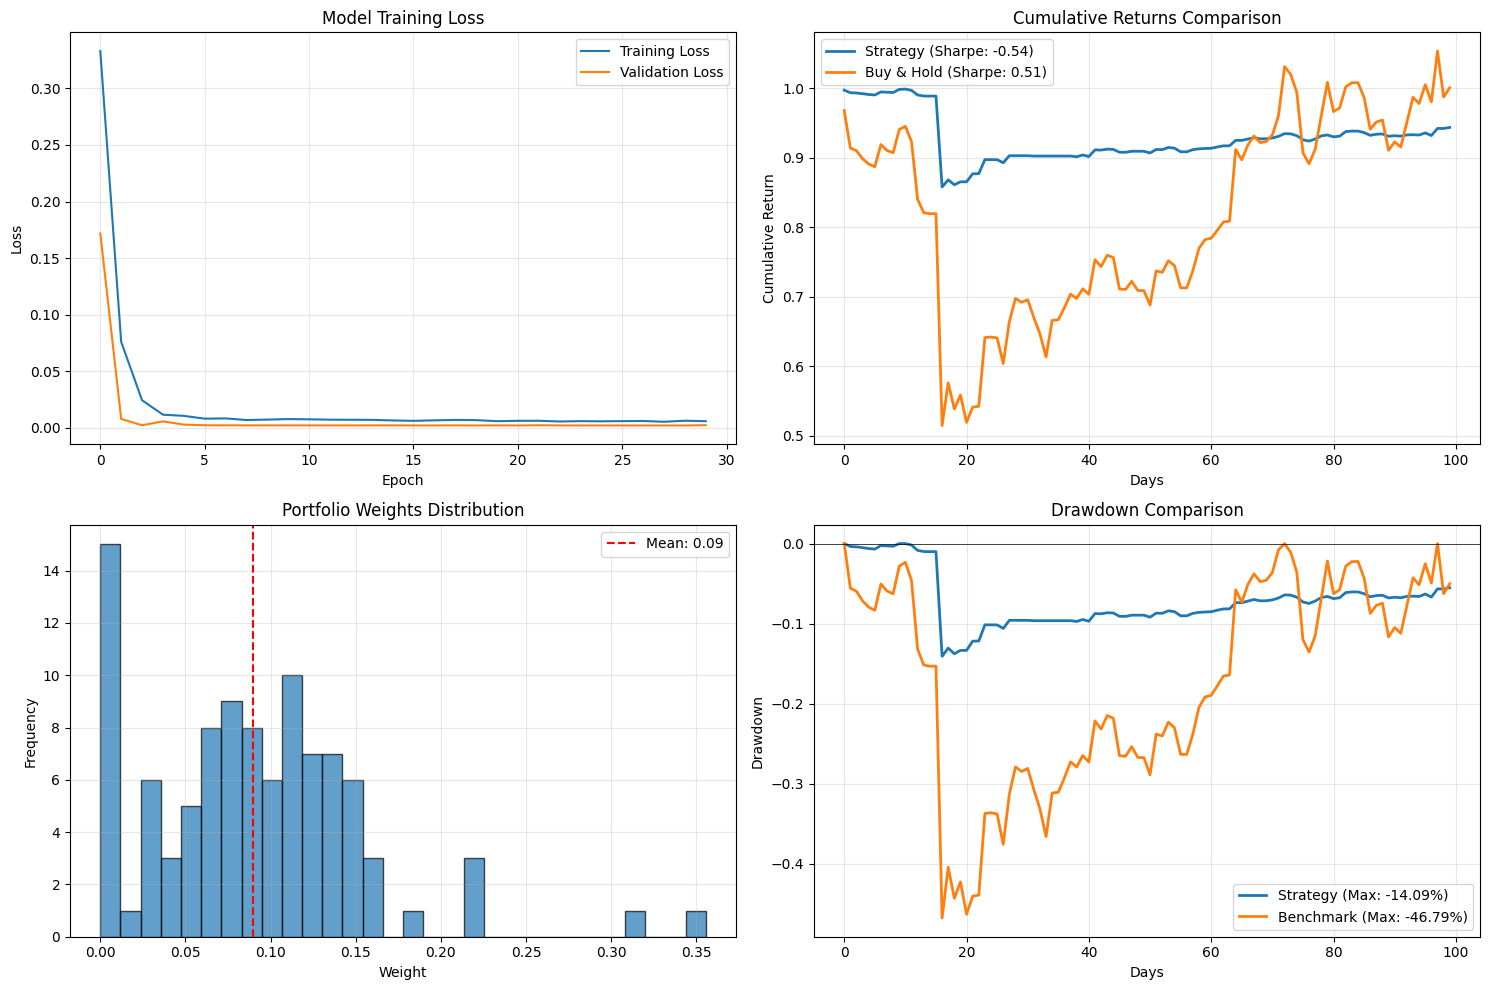


✓ All steps completed!

Summary
✓ Data processing: 500 samples
✓ Feature engineering: 12 features
✓ Model training: Completed
✓ Strategy implementation: Satisfies volatility constraint (≤ 1.2×)
✓ Strategy Sharpe Ratio: -0.541
✓ Excess return vs benchmark: -5.69%


In [ ]:
eatures")
print(f"✓ Model training: Completed")
print(f"✓ Strategy implementation: Satisfies volatility constraint (≤ 1.2×)")
print(f"✓ Strategy Sharpe Ratio: {strategy_sharpe:.3f}")
print(f"✓ Excess return vs benchmark: {(strategy_cumret - benchmark_cumret):.2%}")